<a href="https://colab.research.google.com/github/vivekmoningi/Automatic-Ticket-Classification/blob/main/Automatic_Ticket_Classification_Assignment_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [3]:
#importing necessary packages

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string, pprint
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# downloading nltk packages

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') 
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file 
f = open('/content/drive/MyDrive/complaints.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.

df.shape

(78313, 22)

In [ ]:
#print the column names
df.head(5)

In [9]:
#checking info of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
# storing the columns in cols_list

cols_list = df.columns
cols_list

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names
#removing _ from the column name
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)


['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
# checking the number of nan values
round(df.isna().sum()/df.shape[0]*100,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [13]:
#describe to understand the statistics
df.describe()

,score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [14]:
# Counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

57241

In [15]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [16]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

In [17]:
df.head(10)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,Can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,With out notice J.P. Morgan Chase restricted m...,Funds not received from closed account,Consent provided
20,complaint-public-v2,complaint,3352857,0.0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-24T12:00:00-05:00,None,Loan,Yes,"During the summer months, I experience a decli...",Denied request to lower payments,Consent provided
21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-29T12:00:00-05:00,None,Domestic (US) money transfer,Yes,"On XXXX XX/XX/2019, I made a {$300.00} payment...",None,Consent provided
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,...,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-05-09T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have a Chase credit card which is incorrectl...,Account information incorrect,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
  text = text.lower()

  # to remove square brackets
  text = re.sub(r'\[.*?\]','',text)
  
  # to remove punctations
  text = text.translate(str.maketrans('', '', string.punctuation))

  #to remove words containing numbers
  text = re.sub(r'\w*\d\w*','',text)

  return text


In [19]:
# applying the clean text for complaints
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [20]:
# checking 10 rows of values

df['complaint_what_happened'][:10]

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in  and was told ...
10    chase card was reported on  however fraudulent...
11    on  while trying to book a xxxx  xxxx  ticket ...
14    my grand son give me check for  i deposit it i...
15                        can you please remove inquiry
17    with out notice jp morgan chase restricted my ...
20    during the summer months i experience a declin...
21    on xxxx  i made a  payment to an online retail...
23    i have a chase credit card which is incorrectl...
Name: complaint_what_happened, dtype: object

In [28]:
# a function to lemmatize and POS removed
def lemmatization_POS_removed(texts, allowed_postags=['NN']):
    """https://spacy.io/api/annotation"""
    #texts_out = []

    doc = nlp(texts)
    
    result = ' '.join([token.lemma_ for token in doc if token.tag_ in allowed_postags])
    
    return result

In [31]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened','Lemm_Complaints']]

In [32]:
df_clean.head()

,complaint_what_happened,Lemm_Complaints
1,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told ...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card application identity consent credit...
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...


In [35]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  nn_words = []
  doc = nlp(text)
  for tok in doc:
      if(tok.tag_ == 'NN'):
        nn_words.append(tok.lemma_)
  nn_words_str = " ".join(nn_words)
  return nn_words_str


#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['Lemm_Complaints']), axis=1)



In [36]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,Lemm_Complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name debt verification statement bank ...
2,i upgraded my xxxx xxxx card in and was told ...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card application identity consent credit...,chase card application identity consent credit...
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...,ticket offer ticket card information minute sc...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account money son money bank check owner count...


In [37]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [38]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[114, 95, 65, 339, 90, 7, 329, 413, 850, 45]

Text(0, 0.5, 'No. of Complaints')

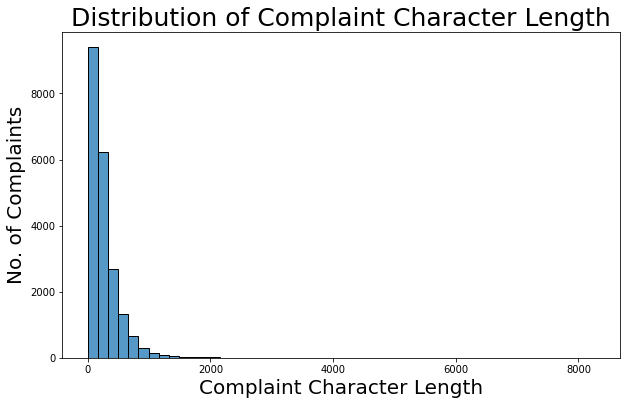

In [39]:
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

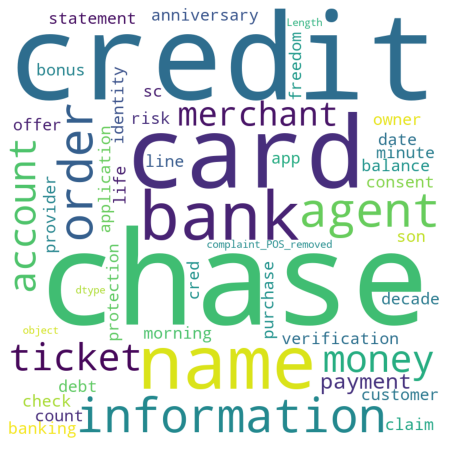

In [40]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
comment_words = ''
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [42]:
#checking the size
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def top_grams(grams,n=30):
    vector = CountVectorizer(ngram_range=(grams,grams), stop_words='english').fit(df_clean['Complaint_clean'])
    bag_of_words = vector.transform(df_clean['Complaint_clean'])
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [45]:
#Print the top 10 words in the unigram frequency

df_unigram = pd.DataFrame(top_grams(1),columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,54558
1,account,34984
2,credit,31312
3,card,25991
4,payment,13754
5,time,11503
6,money,11392
7,loan,9410
8,information,9246
9,bank,8361


In [46]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(top_grams(2),columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,10770
1,chase credit,4088
2,account chase,3423
3,chase account,3157
4,credit report,2964
5,account account,2922
6,customer service,2765
7,chase chase,2482
8,card chase,2171
9,chase card,1860


In [47]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(top_grams(3),columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2268
1,credit card chase,938
2,credit card account,859
3,credit card company,820
4,credit card credit,711
5,chase customer service,555
6,card credit card,519
7,account chase account,462
8,credit report credit,413
9,chase account chase,392


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [48]:
# Replacing XXXX with Null

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [51]:
#checking number of rows with null

len(df_clean[df_clean['Complaint_clean'] == ""])

61

In [52]:
# replacing the null with na

df_clean['Complaint_clean'].replace("", np.nan, inplace=True)

In [54]:
#checking shape of df_clean

df_clean.shape

(21072, 4)

In [86]:
#dropping na values

df_clean.dropna(subset=['Complaint_clean'], inplace=True)

In [88]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,Lemm_Complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name debt verification statement bank ...,morning name debt verification statement bank ...
2,i upgraded my xxxx xxxx card in and was told ...,agent anniversary date agent information order...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card application identity consent credit...,chase card application identity consent credit...,chase card application identity consent credit...
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...,ticket offer ticket card information minute sc...,ticket offer ticket card information minute sc...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account money son money bank check owner count...,account money son money bank check owner count...


In [89]:
#checking if df_clean have any na values
df_clean['Complaint_clean'].isna().sum()

0

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [90]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [91]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [93]:
#shape of the dtm
dtm.shape

(21011, 4362)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [95]:
#importing packages of sklearn

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

#### Using Coherence Model to select best number of Topics

In [96]:
#installing necessary package genism
pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter
from gensim import corpora

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['Complaint_clean']
dataset = [d.split() for d in texts]

dictionary = corpora.Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

#print(cm.get_coherence())

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


In [98]:
#Load your nmf_model with the n_components i.e 5
num_topics = best_num_topics

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [99]:
#to fit the model
nmf_model.fit(dtm)
# checking total count of features names
len(tfidf.get_feature_names())

4362

In [100]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,credit,charge,fraud,dispute,company,merchant,purchase,fee,time,debit,phone,customer,number
Topic 2,credit,report,inquiry,score,debt,information,account,limit,identity,reporting,company,theft,history,file,application
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,time,rate,letter,sale,information,process,application,debt
Topic 4,account,money,chase,check,bank,branch,number,deposit,business,information,customer,phone,transaction,fraud,day
Topic 5,payment,balance,month,statement,fee,date,time,auto,chase,bank,day,error,car,history,phone


In [101]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([3, 3, 1, ..., 3, 4, 4])

In [102]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [106]:
#Print the first 5 Complaint for each of the Topics
df_clean_5 = df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,Lemm_Complaints,complaint_POS_removed,Complaint_clean,Topic
32,my chase amazon card was declined for a cateri...,chase amazon card catering order funeral amoun...,amazon card catering order funeral amount chas...,amazon card catering order funeral amount chas...,0
59,i currently have over xxxx chase ultimate rewa...,chase bonus chase freedom page request time im...,chase bonus chase freedom page request time im...,chase bonus chase freedom page request time im...,0
52,my roommate was stealing my chase debit card a...,roommate chase debit card license money accoun...,roommate chase debit card license money accoun...,roommate chase debit card license money accoun...,0
40,xxxx xxxx a sofa love seat table and chairs an...,sofa love seat table debit card bank claim fur...,love seat table debit card bank claim furnitur...,love seat table debit card bank claim furnitur...,0
50,i am a senior citizen that has been scammed by...,citizen time share nothing refund credit card ...,citizen time nothing credit card information c...,citizen time nothing credit card information c...,0
10,chase card was reported on however fraudulent...,chase card application identity consent credit...,chase card application identity consent credit...,chase card application identity consent credit...,1
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...,ticket offer ticket card information minute sc...,ticket offer ticket card information minute sc...,1
15,can you please remove inquiry,inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,chase credit card credit report company issue,1
26,i have reached out to xxxx several times in at...,attempt inquiry creditor inquiry report chase ...,inquiry creditor inquiry inquiry person care i...,inquiry creditor inquiry inquiry person care i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:

* Topic 0: Credit card or prepaid card
* Topic 1: Theft/Dispute Reporting
* Topic 2: Mortgage/Loan
* Topic 3: Bank Account services
* Topic 4: Others

In [107]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Credit card or prepaid card', 1:'Theft/Dispute Reporting', 2:'Mortgage/Loan', 3:'Bank Account services', 4:'Others'   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [108]:
# checking the valeus are re-mapping
df_clean.head(5)

,complaint_what_happened,Lemm_Complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name debt verification statement bank ...,morning name debt verification statement bank ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,agent anniversary date agent information order...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank Account services
10,chase card was reported on however fraudulent...,chase card application identity consent credit...,chase card application identity consent credit...,chase card application identity consent credit...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...,ticket offer ticket card information minute sc...,ticket offer ticket card information minute sc...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account money son money bank check owner count...,account money son money bank check owner count...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [110]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Credit card or prepaid card':0, 'Theft/Dispute Reporting':1, 'Mortgage/Loan':2, 'Bank Account services':3, 'Others':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [111]:
df_clean

,complaint_what_happened,Lemm_Complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,morning name debt verification statement bank ...,morning name debt verification statement bank ...,3
2,i upgraded my xxxx xxxx card in and was told ...,agent anniversary date agent information order...,agent anniversary date agent information order...,agent anniversary date agent information order...,3
10,chase card was reported on however fraudulent...,chase card application identity consent credit...,chase card application identity consent credit...,chase card application identity consent credit...,1
11,on while trying to book a xxxx xxxx ticket ...,ticket offer ticket card information offer min...,ticket offer ticket card information minute sc...,ticket offer ticket card information minute sc...,1
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account money son money bank check owner count...,account money son money bank check owner count...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,0
78310,i am not familiar with xxxx pay and did not un...,pay risk chase bank app chase banking merchant...,risk chase app chase banking merchant merchant...,risk chase app chase banking merchant merchant...,3
78311,i have had flawless credit for yrs ive had ch...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...,4


In [112]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [113]:
#checking training data
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,3
2,i upgraded my xxxx xxxx card in and was told ...,3
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,3
...,...,...
78303,after being a chase card customer for well ove...,0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,0
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,4


In [114]:
#training data shape

training_data.shape

(21011, 2)

In [135]:
# View value counts of the five topics
training_data['Topic'].value_counts()

3    6416
0    4885
2    3845
1    3693
4    2172
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [115]:

#Write your code to get the Vector count
count_vector = CountVectorizer()
X_train_counts = count_vector.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [116]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [117]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

In [118]:
# shapes of X_train, y_Train, X_test, y_test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15758, 33592)
Shape of y_train: (15758,)
Shape of X_test: (5253, 33592)
Shape of y_test: (5253,)


#### 1. Logistic Regression

In [137]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted_lr = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted_lr))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1219
           1       0.92      0.87      0.89       908
           2       0.91      0.90      0.91       970
           3       0.90      0.93      0.92      1624
           4       0.93      0.80      0.86       532

    accuracy                           0.90      5253
   macro avg       0.91      0.89      0.89      5253
weighted avg       0.90      0.90      0.90      5253



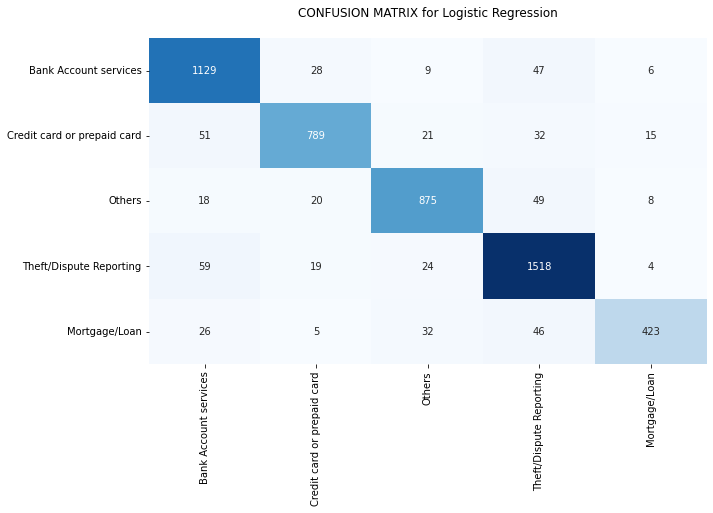

In [138]:
    # confusion matrix
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for Logistic Regression\n")
    matrix = confusion_matrix(y_test, predicted_lr)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

#### 2. Decision Tree

In [140]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted_dt = dt.predict(X_test)

print(classification_report(y_pred=predicted_dt, y_true=y_test))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1219
           1       0.77      0.74      0.76       908
           2       0.84      0.85      0.85       970
           3       0.85      0.82      0.83      1624
           4       0.76      0.80      0.78       532

    accuracy                           0.81      5253
   macro avg       0.80      0.81      0.81      5253
weighted avg       0.81      0.81      0.81      5253



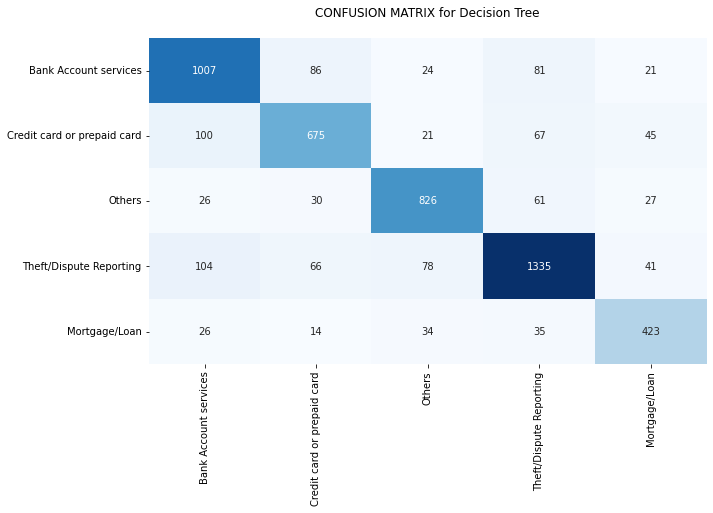

In [143]:
  # confusion matrix
  plt.figure(figsize=(10,6))
  plt.title(f"CONFUSION MATRIX for Decision Tree\n")
  matrix = confusion_matrix(y_test, predicted_dt)
  sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
  plt.show()

#### 3. Random Forest Classifier

In [144]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted_rfc = rfc.predict(X_test)

print(classification_report(y_pred=predicted_rfc, y_true=y_test))

              precision    recall  f1-score   support

           0       0.74      0.49      0.59      1219
           1       0.85      0.37      0.51       908
           2       0.86      0.65      0.74       970
           3       0.48      0.97      0.64      1624
           4       0.00      0.00      0.00       532

    accuracy                           0.60      5253
   macro avg       0.59      0.50      0.50      5253
weighted avg       0.63      0.60      0.56      5253



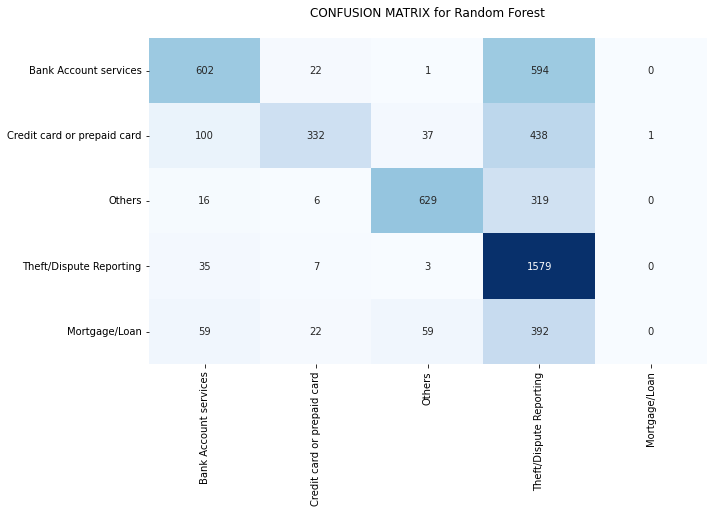

In [146]:
  # confusion matrix
  plt.figure(figsize=(10,6))
  plt.title(f"CONFUSION MATRIX for Random Forest\n")
  matrix = confusion_matrix(y_test, predicted_rfc)
  sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
  plt.show()

#### 4. Gaussian Naive Bayes

In [147]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted_nb = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted_nb, y_true=y_test))

              precision    recall  f1-score   support

           0       0.42      0.35      0.38      1219
           1       0.29      0.27      0.28       908
           2       0.52      0.47      0.49       970
           3       0.46      0.26      0.33      1624
           4       0.13      0.40      0.20       532

    accuracy                           0.34      5253
   macro avg       0.36      0.35      0.34      5253
weighted avg       0.40      0.34      0.35      5253



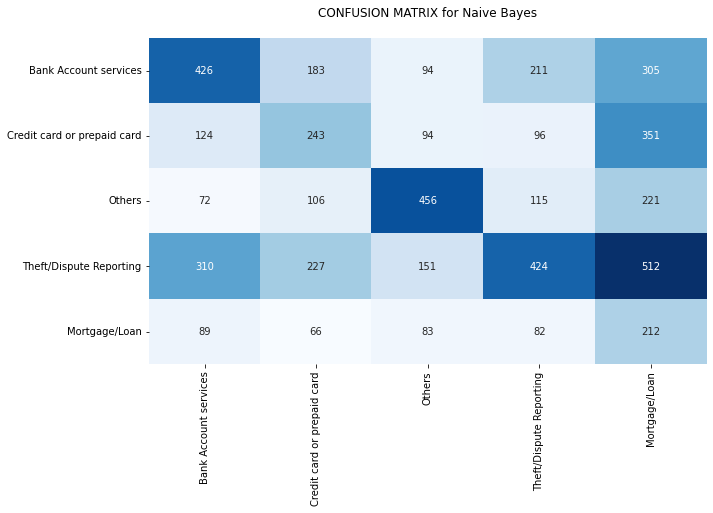

In [148]:
  # confusion matrix
  plt.figure(figsize=(10,6))
  plt.title(f"CONFUSION MATRIX for Naive Bayes\n")
  matrix = confusion_matrix(y_test, predicted_nb)
  sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
  plt.show()

Based on the accuracy of the 4 models Logistic Regression did a better job compared to 4 with 90% accuracy.

The best model will be Logistic Regression

#### Infering the best model

In [125]:
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [129]:
def predict_lr(text):
    Topic_names = {0:'Credit card or prepaid card', 1:'Theft/Dispute Reporting', 2:'Mortgage/Loan', 3:'Bank Account services', 4:'Others'   }
    X_new_counts = count_vector.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [130]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Credit card or prepaid card
4,What is the procedure to know my CIBIL score?,Theft/Dispute Reporting
5,I need to know the number of bank branches and...,Bank Account services
